### HW1

**Author**: Ben Peloquin
    
**Date**: 20190406


Todos

1.1.1
* Run multiple variation levels

1.1.2
* Run multiple variation levels


1.1.2.b 
* Better diagnosis

1.1.2.c
* Run t-tests


In [1]:
from collections import defaultdict
import h5py
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import tqdm
import sys

# Get access to psych253 utils
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from psych253.metrics import *

# Bespoke Hw1 utils
from hw1_utils import *

sns.set_style("whitegrid")

%matplotlib inline

Load data

In [2]:
data_fp = "ventral_neural_data.hdf5"
d_ventral = h5py.File(data_fp, 'r')
print(d_ventral.keys())

[u'image_meta', u'images', u'neural_meta', u'time_averaged', u'time_averaged_trial_averaged', u'time_binned', u'time_binned_trial_averaged']


Utils

In [3]:
def dimnames(dataset):
    dims = dataset.dims  #get the dimension object
    dimlist = [x.label for x in dims.keys()]  #get the label attribute
    dimlist = map(str, dimlist)  #cast everything to string instead of "unicode" ... complicated rathole ... not strictly necessary
    return dimlist

In [4]:
#let's get the IT neural data -- time and trial averaged
d_neural = d_ventral['time_averaged_trial_averaged']
it_neurons = d_ventral['neural_meta']['IT_NEURONS']
d_it_neurons = d_neural[:, it_neurons]

#... and remind ourselves of the tensor shape
# print('Shape:', d_it_neurons.shape)
# print('Dimensions:', list(dimnames(d_neural)))

Basic data

In [5]:
d_time_averaged = d_ventral['time_averaged']
print(d_time_averaged['variation_level_0'].shape)
print(d_time_averaged['variation_level_3'].shape)
print(d_time_averaged['variation_level_6'].shape)
print("Reminder about dims:")
print(list(d_time_averaged['variation_level_0'].dims.keys()))

(28, 640, 296)
(51, 2560, 296)
(47, 2560, 296)
Reminder about dims:
[<"trial" dimension 0 of HDF5 dataset at 112139670736>, <"image" dimension 1 of HDF5 dataset at 112139670736>, <"neuron" dimension 2 of HDF5 dataset at 112139670736>]


## Problem 1.1: Reliability computation on time-averaged responses

Outstanding things (Ben / Marc):
* Do we want to aggregate over conditions?
* Can we use random indices permutations for all neurons? (for runtime efficiency)

### 1.1.a Reliability by neuron
* First compute the reliability for each neuron using the methods described in the class
* Perform a significance test on the population of all the neurons to determine whether the population is significantly reliable or not

In the report, please describe your methods for computing the reliability, choose your own significance level, and report the results of significance test properly (refer to section 3 for details).

[BP] We'll use `split-half reliability` to compute reliability for each neuron. This means we're going to look at average activation for each neuron, aggregating over objects and conditions.

Remember from class we concluded that `having num_splits ~ 10 * num_trials is good enough`



For this first question, we're going to aggregate over specific images, trials and conditions.

In [8]:
run_type = 'efficient'

variation_levels = [0]
results = {}
t0 = time.time()
for lvl in variation_levels:
    results[lvl] = get_reliability_by_variation_level(d_time_averaged, lvl, type_=run_type)
print("Runtime: {}".format(time.time() - t0))

 44%|████▎     | 129/296 [00:47<01:01,  2.73it/s]

KeyboardInterrupt: 

In [44]:
def plot_neuron_reliability_at_level(level, means, stds):
    neurons = np.arange(296)
    plt.plot(neurons, means)
    plt.fill_between(neurons, means - stds, means + stds, color='b', alpha = 0.2)
    plt.ylabel("Correlation")
    plt.xlabel("Neuron")
    plt.title("Variation level {}".format(level))
    return plt

In [45]:
plot_neuron_reliability_at_level(3, results[0][0], results[0][1])

KeyError: 0

### Population-level reliability

We can test this formally assessing whether the population average is significantly different from 0.

In [8]:
plt.hist(results[0][0])
plt.ylabel("Count")
plt.xlabel("Correlation")
plt.axvline(x=np.mean(results[0][0]), c='red', ls='--')

NameError: name 'results' is not defined

In [17]:
n = len(results[0][0])
stats.ttest_1samp(results[0][0], 0.)

Ttest_1sampResult(statistic=24.318922365628666, pvalue=1.8899296803534524e-72)

* To compute the reliability for a single neuron we used the split-half using `20 splits` with `10 trials` each. For each neuron this gave 20 reliability estimates we used to compute the mean and std.
* We examined the distribution over mean reliability measures for the entire population in the histogram plot and performed a t-test to assess whether the average reliability was significantly different than 0. We found that the population was significantly reliable.
```
 t(295) = 24.31, p < 1e-70
```

### 1.1.b Reliability by areas

Test whether reliability of V4 neurons is significantly different from that of IT neurons.
* Choose a significance level and report the significance test results properly. 


In [9]:
IT_neurons = d_ventral['neural_meta']['IT_NEURONS']
v4_neurons = d_ventral['neural_meta']['V4_NEURONS']
d_it = np.array(d_time_averaged['variation_level_0'])[:, :, IT_neurons]
d_v4 = np.array(d_time_averaged['variation_level_0'])[:, :, v4_neurons]

In [10]:
it_reliabilities = get_all_neuron_reliabilities(d_it, 40, 20)
v4_reliabilities = get_all_neuron_reliabilities(d_v4, 40, 20)

100%|██████████| 128/128 [00:07<00:00, 17.94it/s]


In [11]:
def hist_plot(a, b, a_name=None, b_name=None):
    l0 = plt.hist(a, bins=20);
    l1 = plt.hist(b, bins=20, alpha=0.5);
    if a_name is not None and b_name is not None:
        plt.legend([l0[2][0], l1[2][0]], [a_name, b_name])
    plt.xlabel('Reliabilities (r)')
    plt.ylabel('Count')
    
def hist_plot2(datas, data_names, alpha=0.5):
    for d, name in zip(datas, data_names):
        plt.hist(d, bins=20, alpha=alpha)
        plt.xlabel('Reliabilities (r)')
        plt.ylabel('Count')
    plt.legend(data_names)  

In [12]:
it_means = it_reliabilities.mean(1)
v4_means = v4_reliabilities.mean(1)
it_std = it_reliabilities.std(1)
v4_std = v4_reliabilities.std(1)

Let's create a bar plot with error bars over our average reliabilities by area. Note that we are aggregating over neuron means.

/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


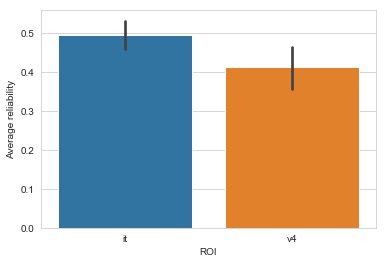

In [13]:
df_bar_plot = pd.DataFrame({
    "ROI": ["it" for _ in range(len(it_means))] + ["v4" for _ in range(len(v4_means))],
    "Average reliability": it_means.tolist() + v4_means.tolist()})
sns.barplot(x="ROI", y="Average reliability", ci=95, data=df_bar_plot)

But let's look the population reliabilities too!

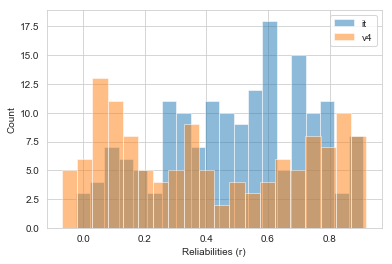

In [14]:
hist_plot2([it_means, v4_means], ['it', 'v4'])

In [15]:
print(np.std(it_means))
print(np.std(v4_means))

print(np.mean(it_std))
print(np.mean(v4_std))

0.23602578
0.3090233
0.018947152
0.019631188


Just a note that we can inspect both the population level variance by taking the standard deviation over area means for each area. We find that, in accordance with our histogram, IT population is less variable than V4. However, if we inspect the average variance for *individual neurons* by taking the mean of the split-half variances we see that there don't appear to be significant differences between populations!

In [16]:
n1 = len(it_means)
n2 = len(v4_means)
dof = n1 + n2 - 2
print(dof)
stats.ttest_ind(it_means, v4_means, equal_var=False)

294


Ttest_indResult(statistic=2.4452137320767555, pvalue=0.015227368229589412)

Under a two-sample t-test the IT neurons appear to be significnatly more reliable at a significance level of 0.05 for the variation 0 data.

```
t(294) = 2.45, p = .015
```


### 1.1.c Reliability by animal

Validate that neurons in each animal and also each electrode array agenerating reliable responses.
* Choose a significance level and report the significance test results properly. 
* After grouping neurons by animals, please perform significance test to both animals and report the results. Similarly, please also plot a histogram of reliability of neurons in two animals


In [17]:
chabo_idxs = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Chabo'
tito_idxs = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Tito'
it_idxs = d_ventral['neural_meta']["IT_NEURONS"][:] == "IT"
d_chabo = d_time_averaged['variation_level_0'][:, :, chabo_idxs]
d_tito = d_time_averaged['variation_level_0'][: , :, tito_idxs]

/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# Get reliabilites
chabo_reliabilities = get_all_neuron_reliabilities(d_chabo, 20, 10)
tito_reliabilities = get_all_neuron_reliabilities(d_tito, 20, 10)

100%|██████████| 168/168 [00:12<00:00, 14.45it/s]


In [19]:
# Get means
chabo_means = chabo_reliabilities.mean(1)
tito_means = tito_reliabilities.mean(1)
chabo_std = chabo_reliabilities.std(1)
tito_std = tito_reliabilities.std(1)

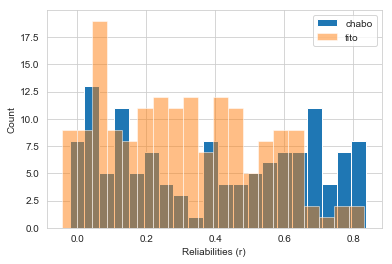

In [20]:
hist_plot(chabo_means, tito_means, 'chabo', 'tito')

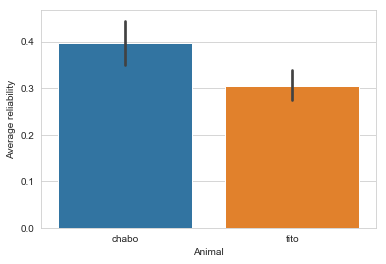

In [21]:
df_bar_plot = pd.DataFrame({
    "Animal": ["chabo" for _ in range(len(chabo_means))] + ["tito" for _ in range(len(tito_means))],
    "Average reliability": chabo_means.tolist() + tito_means.tolist()})
sns.barplot(x="Animal", y="Average reliability", ci=95, data=df_bar_plot)

In [22]:
n1 = len(chabo_means)
n2 = len(tito_means)
dof = n1 + n2 - 2
print(dof)
stats.ttest_ind(chabo_means, tito_means, equal_var=False)

294


Ttest_indResult(statistic=3.1601525908843624, pvalue=0.0017841030854144518)

Under a two-sample t-test the Chabo appears to be significantly more reliable at a significance leve of 0.05 for variation 0 data.

```
t(294) = 3.16, p < .001
```


### 1.1.d Reliability by electrode arrays

You need to combine this information with “ANIMAL INFO” to group the neurons by six electrode arrays, e.g. the neurons belonging to “Chabo” and array “P”

In [23]:
import itertools as it

animals = ["Chabo", "Tito"]
areas = ["P", "M", "A"]
combinations = list(it.product(animals, areas))

# Create filters
filters = {}
for animal, area in combinations:
    animal_filter = d_ventral['neural_meta']['ANIMAL_INFO'][:] == animal
    area_filter = d_ventral['neural_meta']['ARRAY_INFO'][:] == area
    combination_filter = animal_filter & area_filter
    filters[animal + "_" + area] = combination_filter

In [24]:
# Get reliability data
results = {}
for animal_area, curr_filter in filters.items():
    d = d_time_averaged["variation_level_0"][:, :, curr_filter]
    results[animal_area] = get_all_neuron_reliabilities(d, 20, 10).mean(1)

100%|██████████| 40/40 [00:00<00:00, 81.70it/s]


Text(0.5,1,'Animal by array reliability')

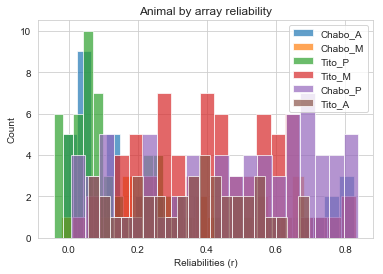

In [25]:
hist_plot2(list(results.values()), list(results.keys()), 0.7)
plt.title("Animal by array reliability")

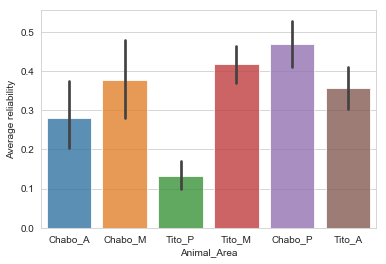

In [26]:
names = []
values = []
for nam, res in results.items():
    names.extend([nam for _ in range(len(res))])
    values.extend(res)

df_bar_plot_animal_area = pd.DataFrame({"Animal_Area": names, "Average reliability": values})
sns.barplot(x="Animal_Area", y="Average reliability", alpha=0.8, ci=95, data=df_bar_plot_animal_area)

## Problem 1.1: Reliability computation on time-averaged responses

### 1.2.a Reliability by areas in each of 20ms bins

In [10]:
ms_groups = d_ventral['time_binned'].keys(); print(ms_groups)
d_time_binned = d_ventral['time_binned']

[u'0ms', u'100ms', u'120ms', u'140ms', u'160ms', u'180ms', u'200ms', u'20ms', u'40ms', u'60ms', u'80ms']


In [13]:
var_level = 0
d_all_ms = {}
for ms in ms_groups:
    d_all_ms[ms] = get_reliability_by_variation_level(d_time_binned[ms], var_level)




  0%|          | 0/296 [00:00<?, ?it/s]


  0%|          | 1/296 [00:00<02:02,  2.41it/s]


  1%|          | 2/296 [00:00<01:59,  2.47it/s]


  1%|          | 3/296 [00:01<01:57,  2.49it/s]


  1%|▏         | 4/296 [00:01<01:55,  2.52it/s]


  2%|▏         | 5/296 [00:02<01:59,  2.44it/s]


  2%|▏         | 6/296 [00:02<01:59,  2.43it/s]


  2%|▏         | 7/296 [00:02<02:02,  2.36it/s]


  3%|▎         | 8/296 [00:03<02:02,  2.35it/s]


  3%|▎         | 9/296 [00:03<02:02,  2.35it/s]


  3%|▎         | 10/296 [00:04<02:03,  2.31it/s]


  4%|▎         | 11/296 [00:04<02:00,  2.37it/s]


  4%|▍         | 12/296 [00:04<01:57,  2.43it/s]


  4%|▍         | 13/296 [00:05<01:54,  2.46it/s]


  5%|▍         | 14/296 [00:05<01:54,  2.46it/s]


  5%|▌         | 15/296 [00:06<01:52,  2.49it/s]


  5%|▌         | 16/296 [00:06<01:51,  2.51it/s]


  6%|▌         | 17/296 [00:06<01:50,  2.53it/s]


  6%|▌         | 18/296 [00:07<01:49,  2.54it/s]


  6%|▋         | 19/296 [00:07<01:49,  2.54it/

 91%|█████████ | 270/296 [01:51<00:10,  2.51it/s]


 92%|█████████▏| 271/296 [01:52<00:09,  2.50it/s]


 92%|█████████▏| 272/296 [01:52<00:09,  2.51it/s]


 92%|█████████▏| 273/296 [01:52<00:09,  2.51it/s]


 93%|█████████▎| 274/296 [01:53<00:08,  2.55it/s]


 93%|█████████▎| 275/296 [01:53<00:08,  2.54it/s]


 93%|█████████▎| 276/296 [01:54<00:07,  2.55it/s]


 94%|█████████▎| 277/296 [01:54<00:07,  2.56it/s]


 94%|█████████▍| 278/296 [01:54<00:06,  2.59it/s]


 94%|█████████▍| 279/296 [01:55<00:06,  2.58it/s]


 95%|█████████▍| 280/296 [01:55<00:06,  2.57it/s]


 95%|█████████▍| 281/296 [01:56<00:05,  2.59it/s]


 95%|█████████▌| 282/296 [01:56<00:05,  2.61it/s]


 96%|█████████▌| 283/296 [01:56<00:05,  2.59it/s]


 96%|█████████▌| 284/296 [01:57<00:04,  2.58it/s]


 96%|█████████▋| 285/296 [01:57<00:04,  2.59it/s]


 97%|█████████▋| 286/296 [01:57<00:03,  2.58it/s]


 97%|█████████▋| 287/296 [01:58<00:03,  2.60it/s]


 97%|█████████▋| 288/296 [01:58<00:03,  2.59it/s]


 98%|███████

 82%|████████▏ | 243/296 [01:33<00:19,  2.77it/s]


 82%|████████▏ | 244/296 [01:33<00:18,  2.75it/s]


 83%|████████▎ | 245/296 [01:34<00:18,  2.72it/s]


 83%|████████▎ | 246/296 [01:34<00:18,  2.69it/s]


 83%|████████▎ | 247/296 [01:34<00:18,  2.68it/s]


 84%|████████▍ | 248/296 [01:35<00:18,  2.65it/s]


 84%|████████▍ | 249/296 [01:35<00:17,  2.65it/s]


 84%|████████▍ | 250/296 [01:36<00:17,  2.64it/s]


 85%|████████▍ | 251/296 [01:36<00:16,  2.66it/s]


 85%|████████▌ | 252/296 [01:36<00:16,  2.69it/s]


 85%|████████▌ | 253/296 [01:37<00:16,  2.67it/s]


 86%|████████▌ | 254/296 [01:37<00:15,  2.69it/s]


 86%|████████▌ | 255/296 [01:37<00:15,  2.68it/s]


 86%|████████▋ | 256/296 [01:38<00:15,  2.67it/s]


 87%|████████▋ | 257/296 [01:38<00:14,  2.67it/s]


 87%|████████▋ | 258/296 [01:39<00:14,  2.65it/s]


 88%|████████▊ | 259/296 [01:39<00:14,  2.63it/s]


 88%|████████▊ | 260/296 [01:39<00:13,  2.61it/s]


 88%|████████▊ | 261/296 [01:40<00:13,  2.60it/s]


 89%|███████

 73%|███████▎  | 215/296 [01:30<00:32,  2.48it/s]


 73%|███████▎  | 216/296 [01:30<00:32,  2.47it/s]


 73%|███████▎  | 217/296 [01:31<00:31,  2.48it/s]


 74%|███████▎  | 218/296 [01:31<00:31,  2.47it/s]


 74%|███████▍  | 219/296 [01:31<00:31,  2.46it/s]


 74%|███████▍  | 220/296 [01:32<00:30,  2.46it/s]


 75%|███████▍  | 221/296 [01:32<00:30,  2.48it/s]


 75%|███████▌  | 222/296 [01:33<00:29,  2.50it/s]


 75%|███████▌  | 223/296 [01:33<00:29,  2.49it/s]


 76%|███████▌  | 224/296 [01:33<00:28,  2.50it/s]


 76%|███████▌  | 225/296 [01:34<00:28,  2.48it/s]


 76%|███████▋  | 226/296 [01:34<00:28,  2.47it/s]


 77%|███████▋  | 227/296 [01:35<00:27,  2.47it/s]


 77%|███████▋  | 228/296 [01:35<00:27,  2.47it/s]


 77%|███████▋  | 229/296 [01:35<00:27,  2.46it/s]


 78%|███████▊  | 230/296 [01:36<00:26,  2.46it/s]


 78%|███████▊  | 231/296 [01:36<00:26,  2.45it/s]


 78%|███████▊  | 232/296 [01:37<00:26,  2.45it/s]


 79%|███████▊  | 233/296 [01:37<00:25,  2.46it/s]


 79%|███████

 64%|██████▎   | 188/296 [01:15<00:42,  2.57it/s]


 64%|██████▍   | 189/296 [01:16<00:41,  2.57it/s]


 64%|██████▍   | 190/296 [01:16<00:41,  2.55it/s]


 65%|██████▍   | 191/296 [01:17<00:41,  2.55it/s]


 65%|██████▍   | 192/296 [01:17<00:41,  2.51it/s]


 65%|██████▌   | 193/296 [01:17<00:40,  2.52it/s]


 66%|██████▌   | 194/296 [01:18<00:39,  2.55it/s]


 66%|██████▌   | 195/296 [01:18<00:39,  2.55it/s]


 66%|██████▌   | 196/296 [01:18<00:39,  2.56it/s]


 67%|██████▋   | 197/296 [01:19<00:38,  2.57it/s]


 67%|██████▋   | 198/296 [01:19<00:37,  2.59it/s]


 67%|██████▋   | 199/296 [01:20<00:37,  2.61it/s]


 68%|██████▊   | 200/296 [01:20<00:36,  2.61it/s]


 68%|██████▊   | 201/296 [01:20<00:36,  2.62it/s]


 68%|██████▊   | 202/296 [01:21<00:35,  2.62it/s]


 69%|██████▊   | 203/296 [01:21<00:35,  2.62it/s]


 69%|██████▉   | 204/296 [01:22<00:34,  2.64it/s]


 69%|██████▉   | 205/296 [01:22<00:34,  2.63it/s]


 70%|██████▉   | 206/296 [01:22<00:34,  2.64it/s]


 70%|██████▉

 54%|█████▍    | 160/296 [01:00<00:50,  2.69it/s]


 54%|█████▍    | 161/296 [01:00<00:50,  2.67it/s]


 55%|█████▍    | 162/296 [01:01<00:49,  2.69it/s]


 55%|█████▌    | 163/296 [01:01<00:49,  2.71it/s]


 55%|█████▌    | 164/296 [01:01<00:49,  2.68it/s]


 56%|█████▌    | 165/296 [01:02<00:48,  2.67it/s]


 56%|█████▌    | 166/296 [01:02<00:48,  2.68it/s]


 56%|█████▋    | 167/296 [01:02<00:47,  2.70it/s]


 57%|█████▋    | 168/296 [01:03<00:48,  2.67it/s]


 57%|█████▋    | 169/296 [01:03<00:48,  2.64it/s]


 57%|█████▋    | 170/296 [01:04<00:48,  2.59it/s]


 58%|█████▊    | 171/296 [01:04<00:48,  2.55it/s]


 58%|█████▊    | 172/296 [01:04<00:48,  2.55it/s]


 58%|█████▊    | 173/296 [01:05<00:48,  2.54it/s]


 59%|█████▉    | 174/296 [01:05<00:48,  2.50it/s]


 59%|█████▉    | 175/296 [01:06<00:48,  2.49it/s]


 59%|█████▉    | 176/296 [01:06<00:48,  2.50it/s]


 60%|█████▉    | 177/296 [01:06<00:47,  2.51it/s]


 60%|██████    | 178/296 [01:07<00:47,  2.51it/s]


 60%|██████ 

 45%|████▍     | 133/296 [00:51<01:03,  2.57it/s]


 45%|████▌     | 134/296 [00:51<01:03,  2.56it/s]


 46%|████▌     | 135/296 [00:51<01:02,  2.56it/s]


 46%|████▌     | 136/296 [00:52<01:02,  2.55it/s]


 46%|████▋     | 137/296 [00:52<01:02,  2.56it/s]


 47%|████▋     | 138/296 [00:53<01:01,  2.55it/s]


 47%|████▋     | 139/296 [00:53<01:01,  2.54it/s]


 47%|████▋     | 140/296 [00:53<01:01,  2.54it/s]


 48%|████▊     | 141/296 [00:54<01:01,  2.53it/s]


 48%|████▊     | 142/296 [00:54<01:00,  2.53it/s]


 48%|████▊     | 143/296 [00:55<01:00,  2.53it/s]


 49%|████▊     | 144/296 [00:55<01:00,  2.52it/s]


 49%|████▉     | 145/296 [00:55<01:00,  2.50it/s]


 49%|████▉     | 146/296 [00:56<00:59,  2.52it/s]


 50%|████▉     | 147/296 [00:56<00:59,  2.49it/s]


 50%|█████     | 148/296 [00:57<00:59,  2.47it/s]


 50%|█████     | 149/296 [00:57<01:00,  2.44it/s]


 51%|█████     | 150/296 [00:57<00:59,  2.44it/s]


 51%|█████     | 151/296 [00:58<00:58,  2.46it/s]


 51%|█████▏ 

 36%|███▌      | 106/296 [00:37<01:07,  2.82it/s]


 36%|███▌      | 107/296 [00:38<01:06,  2.83it/s]


 36%|███▋      | 108/296 [00:38<01:06,  2.82it/s]


 37%|███▋      | 109/296 [00:38<01:06,  2.82it/s]


 37%|███▋      | 110/296 [00:39<01:06,  2.81it/s]


 38%|███▊      | 111/296 [00:39<01:05,  2.81it/s]


 38%|███▊      | 112/296 [00:39<01:05,  2.81it/s]


 38%|███▊      | 113/296 [00:40<01:05,  2.81it/s]


 39%|███▊      | 114/296 [00:40<01:04,  2.82it/s]


 39%|███▉      | 115/296 [00:40<01:04,  2.80it/s]


 39%|███▉      | 116/296 [00:41<01:04,  2.80it/s]


 40%|███▉      | 117/296 [00:41<01:04,  2.80it/s]


 40%|███▉      | 118/296 [00:42<01:03,  2.81it/s]


 40%|████      | 119/296 [00:42<01:03,  2.80it/s]


 41%|████      | 120/296 [00:42<01:02,  2.80it/s]


 41%|████      | 121/296 [00:43<01:02,  2.80it/s]


 41%|████      | 122/296 [00:43<01:02,  2.78it/s]


 42%|████▏     | 123/296 [00:43<01:02,  2.79it/s]


 42%|████▏     | 124/296 [00:44<01:01,  2.79it/s]


 42%|████▏  

 26%|██▋       | 78/296 [00:28<01:17,  2.82it/s]


 27%|██▋       | 79/296 [00:28<01:16,  2.82it/s]


 27%|██▋       | 80/296 [00:29<01:16,  2.82it/s]


 27%|██▋       | 81/296 [00:29<01:16,  2.82it/s]


 28%|██▊       | 82/296 [00:29<01:16,  2.81it/s]


 28%|██▊       | 83/296 [00:30<01:15,  2.82it/s]


 28%|██▊       | 84/296 [00:30<01:15,  2.80it/s]


 29%|██▊       | 85/296 [00:31<01:17,  2.72it/s]


 29%|██▉       | 86/296 [00:31<01:17,  2.70it/s]


 29%|██▉       | 87/296 [00:31<01:23,  2.50it/s]


 30%|██▉       | 88/296 [00:32<01:30,  2.30it/s]


 30%|███       | 89/296 [00:32<01:29,  2.31it/s]


 30%|███       | 90/296 [00:33<01:38,  2.09it/s]


 31%|███       | 91/296 [00:33<01:33,  2.18it/s]


 31%|███       | 92/296 [00:34<01:34,  2.16it/s]


 31%|███▏      | 93/296 [00:34<01:29,  2.28it/s]


 32%|███▏      | 94/296 [00:35<01:25,  2.38it/s]


 32%|███▏      | 95/296 [00:35<01:21,  2.46it/s]


 32%|███▏      | 96/296 [00:35<01:19,  2.52it/s]


 33%|███▎      | 97/296 [00:36<

 17%|█▋        | 50/296 [00:24<02:10,  1.88it/s]


 17%|█▋        | 51/296 [00:24<02:10,  1.88it/s]


 18%|█▊        | 52/296 [00:25<02:09,  1.88it/s]


 18%|█▊        | 53/296 [00:26<02:10,  1.86it/s]


 18%|█▊        | 54/296 [00:26<02:09,  1.88it/s]


 19%|█▊        | 55/296 [00:27<02:04,  1.93it/s]


 19%|█▉        | 56/296 [00:27<01:55,  2.08it/s]


 19%|█▉        | 57/296 [00:27<01:52,  2.13it/s]


 20%|█▉        | 58/296 [00:28<01:45,  2.25it/s]


 20%|█▉        | 59/296 [00:28<01:40,  2.35it/s]


 20%|██        | 60/296 [00:28<01:37,  2.42it/s]


 21%|██        | 61/296 [00:29<01:35,  2.46it/s]


 21%|██        | 62/296 [00:29<01:34,  2.48it/s]


 21%|██▏       | 63/296 [00:30<01:32,  2.51it/s]


 22%|██▏       | 64/296 [00:30<01:31,  2.55it/s]


 22%|██▏       | 65/296 [00:30<01:30,  2.54it/s]


 22%|██▏       | 66/296 [00:31<01:30,  2.55it/s]


 23%|██▎       | 67/296 [00:31<01:29,  2.56it/s]


 23%|██▎       | 68/296 [00:32<01:28,  2.57it/s]


 23%|██▎       | 69/296 [00:32<

  7%|▋         | 22/296 [00:09<02:00,  2.27it/s]


  8%|▊         | 23/296 [00:09<02:05,  2.17it/s]


  8%|▊         | 24/296 [00:10<01:57,  2.32it/s]


  8%|▊         | 25/296 [00:10<01:56,  2.32it/s]


  9%|▉         | 26/296 [00:11<01:52,  2.40it/s]


  9%|▉         | 27/296 [00:11<01:49,  2.47it/s]


  9%|▉         | 28/296 [00:11<01:46,  2.53it/s]


 10%|▉         | 29/296 [00:12<01:43,  2.59it/s]


 10%|█         | 30/296 [00:12<01:40,  2.64it/s]


 10%|█         | 31/296 [00:12<01:39,  2.66it/s]


 11%|█         | 32/296 [00:13<01:38,  2.68it/s]


 11%|█         | 33/296 [00:13<01:45,  2.50it/s]


 11%|█▏        | 34/296 [00:14<01:54,  2.29it/s]


 12%|█▏        | 35/296 [00:14<01:59,  2.19it/s]


 12%|█▏        | 36/296 [00:15<01:50,  2.35it/s]


 12%|█▎        | 37/296 [00:15<01:50,  2.35it/s]


 13%|█▎        | 38/296 [00:15<01:44,  2.46it/s]


 13%|█▎        | 39/296 [00:16<01:40,  2.56it/s]


 14%|█▎        | 40/296 [00:16<01:37,  2.63it/s]


 14%|█▍        | 41/296 [00:17<

 98%|█████████▊| 291/296 [02:10<00:02,  2.22it/s]


 99%|█████████▊| 292/296 [02:10<00:01,  2.32it/s]


 99%|█████████▉| 293/296 [02:10<00:01,  2.29it/s]


 99%|█████████▉| 294/296 [02:11<00:00,  2.11it/s]


100%|█████████▉| 295/296 [02:11<00:00,  2.12it/s]


100%|██████████| 296/296 [02:12<00:00,  2.27it/s]





  0%|          | 0/296 [00:00<?, ?it/s]


  0%|          | 1/296 [00:00<02:39,  1.85it/s]


  1%|          | 2/296 [00:01<02:35,  1.89it/s]


  1%|          | 3/296 [00:01<02:35,  1.89it/s]


  1%|▏         | 4/296 [00:02<02:27,  1.98it/s]


  2%|▏         | 5/296 [00:02<02:23,  2.02it/s]


  2%|▏         | 6/296 [00:02<02:17,  2.10it/s]


  2%|▏         | 7/296 [00:03<02:15,  2.13it/s]


  3%|▎         | 8/296 [00:03<02:11,  2.19it/s]


  3%|▎         | 9/296 [00:04<02:09,  2.21it/s]


  3%|▎         | 10/296 [00:04<02:10,  2.19it/s]


  4%|▎         | 11/296 [00:05<02:15,  2.11it/s]


  4%|▍         | 12/296 [00:05<02:14,  2.12it/s]


  4%|▍         | 13/296 [00:06<02:13,  2

 89%|████████▉ | 264/296 [01:53<00:14,  2.21it/s]


 90%|████████▉ | 265/296 [01:53<00:14,  2.16it/s]


 90%|████████▉ | 266/296 [01:54<00:14,  2.05it/s]


 90%|█████████ | 267/296 [01:54<00:13,  2.09it/s]


 91%|█████████ | 268/296 [01:54<00:13,  2.14it/s]


 91%|█████████ | 269/296 [01:55<00:12,  2.18it/s]


 91%|█████████ | 270/296 [01:55<00:11,  2.21it/s]


 92%|█████████▏| 271/296 [01:56<00:11,  2.18it/s]


 92%|█████████▏| 272/296 [01:56<00:11,  2.13it/s]


 92%|█████████▏| 273/296 [01:57<00:10,  2.15it/s]


 93%|█████████▎| 274/296 [01:57<00:10,  2.15it/s]


 93%|█████████▎| 275/296 [01:58<00:09,  2.18it/s]


 93%|█████████▎| 276/296 [01:58<00:09,  2.09it/s]


 94%|█████████▎| 277/296 [01:59<00:08,  2.21it/s]


 94%|█████████▍| 278/296 [01:59<00:08,  2.18it/s]


 94%|█████████▍| 279/296 [02:00<00:07,  2.16it/s]


 95%|█████████▍| 280/296 [02:00<00:07,  2.20it/s]


 95%|█████████▍| 281/296 [02:00<00:06,  2.21it/s]


 95%|█████████▌| 282/296 [02:01<00:06,  2.09it/s]


 96%|███████

In [ ]:
if False:
    with open("q1_2_a.pickle", "wb") as fp:
        pickle.dump(d_all_ms, fp) 

In [92]:
# plot variability across time color by neuron
d_time_binned = list()
for ms, (means, stds, _) in tqdm.tqdm(d_all_ms.items()):
    for neuron_idx in range(len(means)):
        d_time_binned.append({
            'ms': ms,
            'neuron_id': neuron_idx,
            'mean': means[neuron_idx],
            'sem': stds[neuron_idx]
        })
df_time_binned = pd.DataFrame(d_time_binned)
print(df_time_binned.columns)





  0%|          | 0/11 [00:00<?, ?it/s]



100%|██████████| 11/11 [00:00<00:00, 2023.92it/s]

Index([u'mean', u'ms', u'neuron_id', u'sem'], dtype='object')


In [107]:
IT_idxs = d_ventral['neural_meta']['IT_NEURONS'][:]
V4_idxs = d_ventral['neural_meta']['V4_NEURONS'][:]

def group_color(neuron_id):
    return 'IT' if neuron_id in IT_idxs else 'V4'

def ms2int(ms_str):
    return int(ms_str[:-2])

def add_jitter(val, scaler=3):
    return val + scaler*np.random.uniform(-1, 1)
    
df_time_binned['ROI'] = df_time_binned['neuron_id'].apply(group_color)
df_time_binned['ms_int'] = df_time_binned['ms'].apply(ms2int)
df_time_binned['ms_int_jitter'] = df_time_binned['ms_int'].apply(add_jitter)

In [114]:
V4_idxs[-40:]

array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294,
       295])

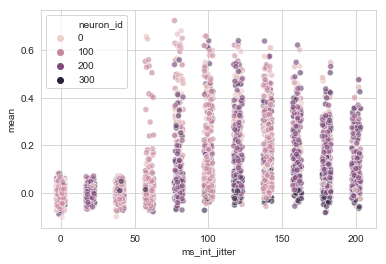

In [110]:
sns.scatterplot(x='ms_int_jitter', y='mean', hue='neuron_id', alpha=0.6, data=df_time_binned.sort_values(by='ms_int'))

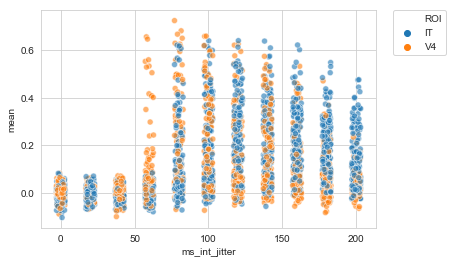

In [112]:
# plot variability across time color area
sns.scatterplot(x='ms_int_jitter', y='mean', hue='ROI', alpha=0.6, data=df_time_binned.sort_values(by='ms_int'))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

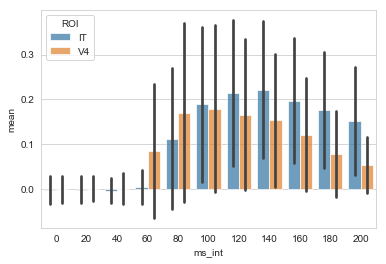

In [131]:
# One more look aggregating by ROI
sns.barplot(y='mean', x='ms_int', hue='ROI', ci="sd", alpha=0.7, data=df_time_binned.sort_values(by='ms_int'))

Not everything is OK! Reliability for all neurons (in both V4 and IT) are really poor prior to 60ms! This is because significant processing doesn't occur until after some delay (clearly after 40ms).

Let's check over areas aggregated..

### 1.2.b Diagnose the problem

**Diagnose quantitatively instead of looking at hint**

Note that in the first plot from `1.2.a` there is a cluster of darker neurons that are all consistently really low for reliability... If we go back to our very first plot of all neuron reliabilities averaged across time bins we see that there is a cluster of neurons (the last bunch) which are really low!

### 1.2.c Difference in V4 and IT neurons

**Todo maybe consider t-tests**

In [149]:
bad_v4_neuron_ids = V4_idxs[-40:]
df_time_binned_good = df_time_binned[~df_time_binned["neuron_id"].isin(bad_v4_neuron_ids)]
df_time_binned_bad = df_time_binned[df_time_binned["neuron_id"].isin(bad_v4_neuron_ids)]

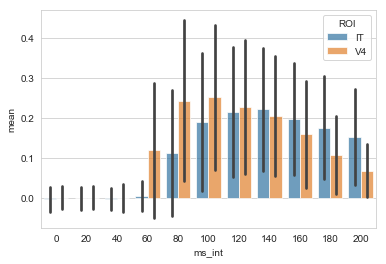

In [156]:
sns.barplot(y='mean', x='ms_int', hue='ROI', ci='sd', alpha=0.7, data=df_time_binned_good.sort_values(by='ms_int'))

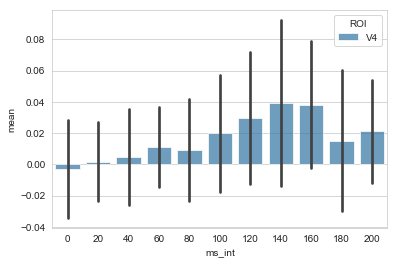

In [158]:
sns.barplot(y='mean', x='ms_int', hue='ROI', ci='sd', alpha=0.7, data=df_time_binned_bad.sort_values(by='ms_int'))

Note that when we remove the bad ones V4 becomes reliable earlier than IT -- V4 becomes reliable at about 80ms while IT only becomes reliable around 100ms. Both remain reliable "longer" when we remove the "bad" neurons, however V4 appears to decline somewhat.

## Problem 1.2: Classifiers

Classifying one of the eight basic object categories in the images. Note that the HW assignment is ambiguous in terms of whether I should treat this as a multi-way classification problem or an eight way classifier. I'm going to default to the latter so all our accuracies reflect an 8-way classification scheme.


### Problem 1.2.1: Regularization

**Note** in the problem description it says that 

In [6]:
# Time averaged trial data
X = d_ventral['time_averaged_trial_averaged'][:]
# Categories
y = d_ventral['image_meta']['category'][:]
assert(X.shape[0] == y.shape[0])

#### Problem 1.2.1.a: Explore lots of models

First we're going to examine performance reliability across train/test split sizes. We'll consider a single baseline model (linear svc without regularization) and compute average accuracy and d_prime.

In [7]:
# Run Params
test_split_sizes = np.arange(0.1, 0.9, 1e-01)
baseline = LinearSVC(C=float(1e-10))  # Baseline uses no (minimal) regulraization
n_splits = 100 # Run each splits sie 100 times...

In [9]:
# Train models
t0 = time.time()
d_test_splits = {}

for i, test_split_size in enumerate(test_split_sizes):
    model_cms, model_runtimes = \
        run_models_over_n_splits([baseline], n_splits, X, y, test_split_size)
    cms = model_cms.values()[0]
    d_test_splits[str(test_split_size)] = evaluate_results(np.stack(cms), set(y))
print("Run time {}".format(time.time() - t0))

  2%|▏         | 2/100 [00:00<00:08, 11.17it/s]

Running 1 models over 100 splits.


  2%|▏         | 2/100 [00:00<00:06, 14.78it/s]

Running 1 models over 100 splits.


  2%|▏         | 2/100 [00:00<00:05, 19.00it/s]

Running 1 models over 100 splits.


  2%|▏         | 2/100 [00:00<00:07, 13.72it/s]

Running 1 models over 100 splits.


  3%|▎         | 3/100 [00:00<00:04, 22.91it/s]

Running 1 models over 100 splits.


  3%|▎         | 3/100 [00:00<00:03, 27.76it/s]

Running 1 models over 100 splits.


  4%|▍         | 4/100 [00:00<00:03, 29.71it/s]

Running 1 models over 100 splits.


  4%|▍         | 4/100 [00:00<00:02, 39.94it/s]

Running 1 models over 100 splits.


100%|██████████| 100/100 [00:03<00:00, 31.54it/s]

Run time 43.4978971481


In [10]:
# Gather data
d_splits = []
for split, res in d_test_splits.items():
    accuracies = res['accuracy_by_split']
    for i in range(len(accuracies)):
        d_splits.append({
            "run_num": i,
            "split": split,
            "accuracy": accuracies[i]
        })
df_splits = pd.DataFrame(d_splits)
df_splits['split'] = df_splits['split'].apply(lambda x: round(float(x), 2))

Let's have a quick look at mean and variance over our splits...

/Users/benpeloquin/anaconda/envs/py27/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


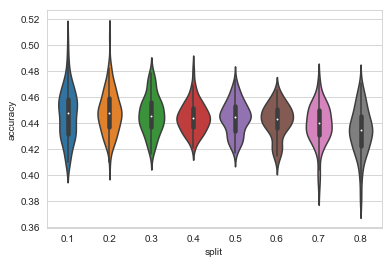

In [11]:
sns.violinplot(x='split', y='accuracy', data=df_splits)

<BarContainer object of 8 artists>

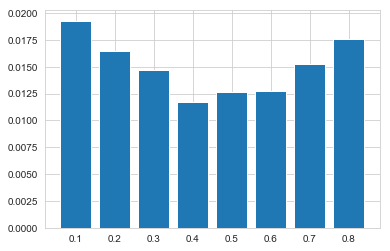

In [12]:
df_stds = df_splits[['split', 'accuracy']].groupby('split') \
    .aggregate({np.std})['accuracy'] \
    .reset_index()
plt.bar([str(x) for x in df_stds['split']], df_stds['std'])

We can verify that we get the most stable estimates with a test size of 0.3 or 0.4. I'd be curious to hear a theoretical justification for why a particualr test parition size might be better worse.

Let's run a model comparison. We'll compare our baseline model to L1 and L2 SVMs varying the weights.

In [13]:
# Run params
weights = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
penalties = ['l1', 'l2']
model_params = list(it.product(penalties, weights, repeat=1))
# Note (BP): Set dual to False as in class
models = map(lambda x: LinearSVC(penalty=x[0], C=x[1], dual=False), model_params)
models = [baseline] + models

In [14]:
# Run models
n_splits = 10
test_size = 0.3
model_cms, model_runtimes = run_models_over_n_splits(models, n_splits, X, y, test_size, True)

  0%|          | 0/10 [00:00<?, ?it/s]

Running 15 models over 10 splits.


100%|██████████| 10/10 [07:15<00:00, 44.26s/it]


In [16]:
# Gather data
d_accuracies = []
for model, cms in model_cms.items():
    results = evaluate_results(np.stack(cms), set(y))
    for split, (acc, dprimes) in enumerate(zip(results['accuracy_by_split'], results['dprime_by_split'])):
        d = {'model': model,
             'split': split,
             'accuracy': acc }
        for i, klass in enumerate(set(y)):
            d['{}_dprime'.format(klass)] = dprimes[i]
        d_accuracies.append(d)
df_accuracies = pd.DataFrame(d_accuracies) 
df_accuracies['model'] = df_accuracies['model'].apply(lambda x: x if str(x) != 'l2_1e-10' else 'baseline') 

Accuracy plot.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

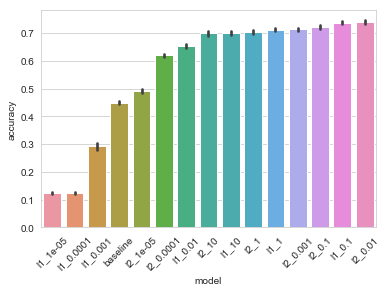

In [17]:
sns.barplot(x='model', y='accuracy',  data=df_accuracies.sort_values('accuracy'))
plt.xticks(rotation=45)

Plot dprimes

In [18]:
d_primes = [c for c in df_accuracies.columns if c[-6:] == 'dprime']
df_dprimes = df_accuracies[[c for c in df_accuracies.columns if c != 'accuracy']] \
    .melt(id_vars=['model', 'split'], value_vars=d_primes, 
          var_name='klass', value_name='score')
df_dprimes['klass'] = df_dprimes['klass'].apply(lambda x: x[:-7])

Let's have a look at d-primes for each class for our three models.

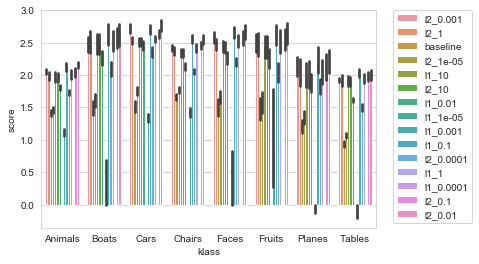

In [24]:
sns.barplot(x='klass', y='score', hue='model', data=df_dprimes)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This is bit hard to make sense of, let's try another way.

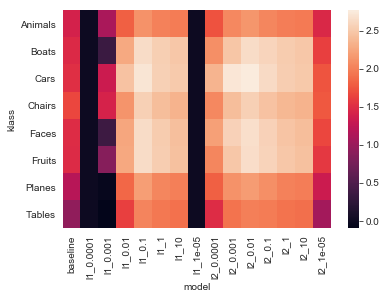

In [50]:
# Draw klass X d_prime score heatmap
d_hm = df_dprimes[['model', 'klass', 'score']] \
    .groupby(['model', 'klass']) \
    .aggregate({np.mean})['score'] \
    .reset_index() \
    .pivot(index='klass', columns='model', values='mean')
sns.heatmap(d_hm)

We can kind of get a better sense of what's happening here -- some klasses are easier for multiple models and `L2_0.01` and `L1_0.1` appear to perform best. We'll verify below...

In [51]:
df_accuracies[['model', 'accuracy']] \
    .groupby('model') \
    .aggregate({np.mean, np.std})['accuracy'] \
    .reset_index() \
    .sort_values('mean', ascending=False)

,model,mean,std
10,l2_0.01,0.738484,0.012180
4,l1_0.1,0.737847,0.008575
11,l2_0.1,0.721933,0.009991
9,l2_0.001,0.714410,0.009180
5,l1_1,0.712905,0.010077
12,l2_1,0.705440,0.012105
6,l1_10,0.700231,0.013348
13,l2_10,0.699016,0.013446
3,l1_0.01,0.654225,0.010002
8,l2_0.0001,0.620139,0.011212


Looks like the best parameterization is the linear SVM with `penalty='L2'` regularization and `C=0.01`. This best model acheives an average accuracy of `0.738484` on my last run.

In general it appears that model is quite sensitive to (either) regularization. That is, we see best performance for both `L1` and `L2` with `C` of `0.1` or `0.01`.

#### Problem 1.2.1.b: Just explore best performaing models

From our runs above we found that the best paramaterizations for each penalty were:
    
    * L2 -> C = 0.01
    * L1 -> C = 0.1
    
We'll now compare our Baseline (no regularization) to our best performing `L1` and `L2`.

In [52]:
# Run models
t0 = time.time()
models = [baseline, LinearSVC(penalty='l2', C=0.01, dual=True), LinearSVC(penalty='l1', C=0.1, dual=False)]
n_splits = 30
test_size = 0.3
model_cms, model_runtimes = run_models_over_n_splits(models, n_splits, X, y, test_size, True)
print("All models ran in {}".format(time.time() - t0))

  0%|          | 0/30 [00:00<?, ?it/s]

Running 3 models over 30 splits.


100%|██████████| 30/30 [02:44<00:00,  5.18s/it]

All models ran in 164.953711033


In [53]:
# Gather data
d_accuracies = []
for model, cms in model_cms.items():
    results = evaluate_results(np.stack(cms), set(y))
    for split, (acc, dprimes) in enumerate(zip(results['accuracy_by_split'], results['dprime_by_split'])):
        d = {'model': model,
             'split': split,
             'accuracy': acc }
        for i, klass in enumerate(set(y)):
            d['{}_dprime'.format(klass)] = dprimes[i]
        d_accuracies.append(d)
df_accuracies = pd.DataFrame(d_accuracies) 
df_accuracies['model'] = df_accuracies['model'].apply(lambda x: x if str(x) != 'l2_1e-10' else 'baseline') 

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

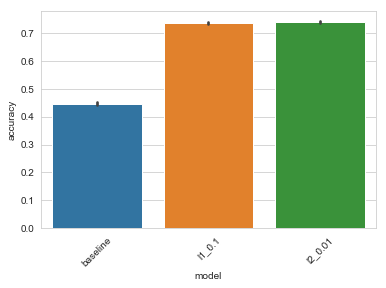

In [54]:
sns.barplot(x='model', y='accuracy',  data=df_accuracies.sort_values('accuracy'))
plt.xticks(rotation=45)

Clearly we're seeing improvements for regularized models. However, it doesn't appear we can distingush between the `L1` and `L2`... We can run a t-tset comparing average accuracy for each model.

In [55]:
stats.ttest_ind(df_accuracies[df_accuracies['model']=='l1_0.1'].accuracy, 
                df_accuracies[df_accuracies['model']=='l2_0.01'].accuracy)

Ttest_indResult(statistic=-0.927869636852461, pvalue=0.35732055125349027)

Simply looking at the distribution over accuracies, we don't see a significant difference between models. This is reflected in our t-test

```
t(29)=-0.93, p=0.36
```

## Problem 1.2.2: Variation levels

Examine how performance depends on variation.

### 1.2.2.a

* Group images into variation levels.
* **For each variation level** - train an SVM with cross-validation and the "best" regularization.
* plot accuracy and d_primes

In [57]:
# Remove bad V4 neurons...
V4_indices = d_ventral['neural_meta']['V4_NEURONS']
bad_v4_indices = V4_indices[-40:]; bad_v4_indices
good_indices = set(range(d_ventral['time_averaged_trial_averaged'][:].shape[1])) - set(bad_v4_indices)

In [59]:
X = d_ventral['time_averaged_trial_averaged'][:, good_indices]
y = d_ventral['image_meta']['category'][:]
labels = set(y)
# Filter by variatino level
d_levels = d_ventral['image_meta']['variation_level'][:]
X0 = X[d_levels=='V0', :]
y0 = y[d_levels=='V0']
X3 = X[d_levels=='V3', :]
y3 = y[d_levels=='V3']
X6 = X[d_levels=='V6', :]
y6 = y[d_levels=='V6']
d_variations = {
    'V0': (X0, y0),
    'V3': (X3, y3),
    'V6': (X6, y6) }

From the last problem we're going to train a Linear SVM with `penalty=L2` and `C=0.01`.

In [60]:
test_split_size = 0.3
best_model_params = {'penalty': 'l2', 'C':0.01, 'dual': False}

In [61]:
# Train models
model_level_variations = {}
for nam, (X_, y_) in d_variations.items():
    model = LinearSVC(**best_model_params)
    X_train, X_test, y_train, y_test =  train_test_split(X_, y_, test_size=test_split_size)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results = evaluate_results(np.expand_dims(get_confusion_matrix(preds, y_test, labels), 0), labels)
    model_level_variations[nam] = (model, results, X_test, y_test)

In [62]:
# Inspect performance by variation level
d_variation_levels = []
for var_level, (model, results, _, _) in model_level_variations.items():
    d_variation_levels.append({
        'var_level': var_level,
        'accuracy': results['mean_accuracy']
    })
    for i, lab in enumerate(labels):
        d_variation_levels[-1][lab] = results['mean_dprime'][i]
    
df_variation_levels = pd.DataFrame(d_variation_levels)

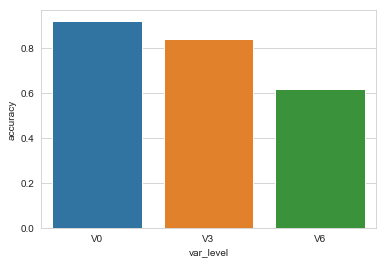

In [63]:
# Accuracy plot
sns.barplot(x='var_level', y='accuracy', data=df_variation_levels)

In [64]:
# Gather dprime data
d_primes = [c for c in df_variation_levels.columns if c not in ['accuracy', 'var_level']]
df_dprime_plot = df_variation_levels[d_primes + ['var_level']] \
    .melt(id_vars=['var_level'], value_vars=d_primes, 
          var_name='klass', value_name='dprime')

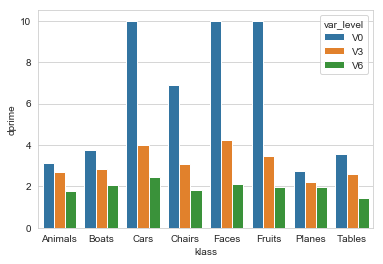

In [65]:
# Dprime performance by klass by variation level
sns.barplot(x='klass', y='dprime', hue='var_level', data=df_dprime_plot)

### 1.2.2.b

* Explore generalization performance across levels
* Train SVM model with regularization on all images belonging to one variation level and test it on images of another level.

First we'll create train/test splits for each variation level.

In [66]:
var_levels = set({'V0', 'V3', 'V6'})

d_generalizations = []
for var_level, (model, _, X_test, y_test) in model_level_variations.items():
    for other_level in var_levels:
        X_test, y_test = model_level_variations[other_level][-2:]
        labels = set(y_test)
        res = evaluate_results(np.expand_dims(get_confusion_matrix(model.predict(X_test), y_test, labels), 0), labels)
        d_generalizations.append({
            'train_variation': var_level,
            'test_variation': other_level,
            'accuracy': res['mean_accuracy']
        })
        
df_generalizations = pd.DataFrame(d_generalizations)   

**Note** the question only asks us to plot validation accuracies...

test_variation         V0        V3        V6
train_variation                              
V0               0.921875  0.580729  0.304688
V3               0.791667  0.842448  0.566406
V6               0.666667  0.763021  0.618490


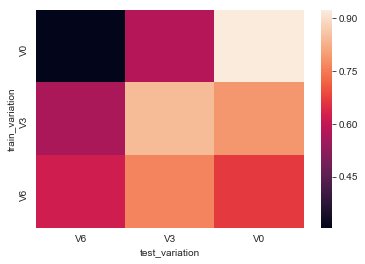

In [67]:
# Plot generalizations
df_generalizations_as_matrix = \
    df_generalizations.pivot(index='train_variation', columns='test_variation', values='accuracy')
print(df_generalizations_as_matrix)
sns.heatmap(df_generalizations_as_matrix[['V6', 'V3', 'V0']])

Some observations -- training on the same variation we see the best performance for each variation level. That is training on `V0` means we perform best on `V0`. Same for `V3` and `V6`. Noteably, performance is overall much better on the lowest `V0`. If we train on `V0` we tend to perform much worse on `V6` than if we had trained on `V3`.

In [68]:
df_generalizations \
    .groupby('train_variation') \
    .aggregate({np.mean})

,accuracy
,mean
train_variation,
V0,0.602431
V3,0.733507
V6,0.682726


Just an observation, if we had to pick one variation level to train on for best generalization we should `V3` looking at aggregate accuracy over all levels.